### Exploratory Data Analysis

This notebook performs exploratory data analysis for the IS584 Term Project dataset (ASAP-Review). It includes:

- Loading metadata and review information across ICLR (2017–2020) and NIPS (2016–2019) conferences.
- Computing dataset statistics (number of papers, reviews).
- Analyzing acceptance rates.
- Analyzing review length statistics and plotting distribution.
- Analyzing reviewer confidence score statistics and plotting distribution.
- Analyzing aspect annotation frequencies.
- Checking for missing or incomplete data.

This EDA ensures basic understanding and quality control of the dataset before modeling.

In [1]:
import os
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from scipy.stats import pearsonr
from scipy.stats import mannwhitneyu

In [2]:
data_root = '/Users/esrasekerci/Desktop/IS584/project/dataset'

In [3]:
def load_metadata_and_reviews(data_root):
    conferences = ['ICLR_2017', 'ICLR_2018', 'ICLR_2019', 'ICLR_2020', 
                   'NIPS_2016', 'NIPS_2017', 'NIPS_2018', 'NIPS_2019']
    
    metadata = []
    reviews = []

    for conf in conferences:
        conf_path = os.path.join(data_root, conf)
        paper_path = os.path.join(conf_path, f"{conf}_paper")
        review_path = os.path.join(conf_path, f"{conf}_review")

        if os.path.isdir(paper_path):
            for file_name in os.listdir(paper_path):
                if file_name.endswith('.json'):
                    with open(os.path.join(paper_path, file_name), 'r') as f:
                        metadata.append(json.load(f))

        if os.path.isdir(review_path):
            for file_name in os.listdir(review_path):
                if file_name.endswith('.json'):
                    with open(os.path.join(review_path, file_name), 'r') as f:
                        review_json = json.load(f)
                        for review in review_json.get('reviews', []):
                            reviews.append(review)
    
    return pd.DataFrame(metadata), pd.DataFrame(reviews)

In [4]:
metadata_df, reviews_df = load_metadata_and_reviews(data_root)

In [5]:
metadata_df.info(), metadata_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8877 entries, 0 to 8876
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          8877 non-null   object
 1   conference  8877 non-null   object
 2   decision    8877 non-null   object
 3   url         8877 non-null   object
 4   hasContent  8877 non-null   object
 5   hasReview   8877 non-null   object
 6   title       8858 non-null   object
 7   authors     8877 non-null   object
dtypes: object(8)
memory usage: 554.9+ KB


(None,
               id conference         decision  \
 0  ICLR_2017_395       ICLR           Reject   
 1  ICLR_2017_281       ICLR           Reject   
 2  ICLR_2017_142       ICLR  Accept (Poster)   
 3   ICLR_2017_31       ICLR  Accept (Poster)   
 4  ICLR_2017_175       ICLR  Accept (Poster)   
 
                                                  url hasContent hasReview  \
 0  http://openreview.net/pdf/c1cfee5be26dee2679a1...       true      true   
 1  http://openreview.net/pdf/2f13fb612ef82e430be7...       true      true   
 2  http://openreview.net/pdf/1b6c5951af988d823360...       true      true   
 3  http://openreview.net/pdf/8463d5bb4a13ac71ddfd...       true      true   
 4  http://openreview.net/pdf/908e82ec04bafe607a8b...       true      true   
 
                                                title  \
 0  RL^2: Fast Reinforcement Learning via Slow Rei...   
 1  A Joint Many-Task Model: Growing a Neural Netw...   
 2  Automatic Rule Extraction from Long Short Term...   

In [6]:
reviews_df.info(), reviews_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28122 entries, 0 to 28121
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   review      28122 non-null  object
 1   rating      15731 non-null  object
 2   confidence  12193 non-null  object
dtypes: object(3)
memory usage: 659.2+ KB


(None,
                                               review  \
 0  The paper is about channel sparsity in Convolu...   
 1  This paper aims to improve efficiency of convo...   
 2  The paper experiments with channel to channel ...   
 3  This paper investigates the impact of orthogon...   
 4  The paper is well-motivated, and is part of a ...   
 
                                      rating  \
 0                     7: Good paper, accept   
 1  5: Marginally below acceptance threshold   
 2     4: Ok but not good enough - rejection   
 3                     7: Good paper, accept   
 4  5: Marginally below acceptance threshold   
 
                                           confidence  
 0  3: The reviewer is fairly confident that the e...  
 1  4: The reviewer is confident but not absolutel...  
 2  4: The reviewer is confident but not absolutel...  
 3  4: The reviewer is confident but not absolutel...  
 4  4: The reviewer is confident but not absolutel...  )

In [7]:
print("Missing values in metadata:")
print(metadata_df.isnull().sum())

Missing values in metadata:
id             0
conference     0
decision       0
url            0
hasContent     0
hasReview      0
title         19
authors        0
dtype: int64


In [8]:
print("Missing values in reviews:")
print(reviews_df.isnull().sum())

Missing values in reviews:
review            0
rating        12391
confidence    15929
dtype: int64


In [9]:
print(f"Number of papers: {len(metadata_df)}")
print(f"Number of individual reviews: {len(reviews_df)}")

Number of papers: 8877
Number of individual reviews: 28122


In [10]:
acceptance_labels = metadata_df['decision'].dropna().apply(lambda x: 'Accept' if 'Accept' in x else 'Reject')
acceptance_counts = acceptance_labels.value_counts()
acceptance_percentages = acceptance_labels.value_counts(normalize=True) * 100

acceptance_summary = pd.DataFrame({
    'Count': acceptance_counts,
    'Percentage (%)': acceptance_percentages
})

print("Acceptance vs Rejection Summary:")
print(acceptance_summary)

Acceptance vs Rejection Summary:
          Count  Percentage (%)
decision                       
Accept     5408       60.921482
Reject     3469       39.078518


In [11]:
total_reviews = len(reviews_df)
total_papers = len(metadata_df)

reviews_per_paper = total_reviews / total_papers

print(f"Total number of papers: {total_papers}")
print(f"Total number of reviews: {total_reviews}")
print(f"Average number of reviews per paper: {reviews_per_paper:.2f}")

Total number of papers: 8877
Total number of reviews: 28122
Average number of reviews per paper: 3.17


In [12]:
reviews_df['review_length'] = reviews_df['review'].astype(str).str.split().apply(len)
print("Review length statistics:")
print(reviews_df['review_length'].describe())

Review length statistics:
count    28122.000000
mean       374.469526
std        247.070190
min          1.000000
25%        207.000000
50%        316.000000
75%        476.000000
max       4540.000000
Name: review_length, dtype: float64


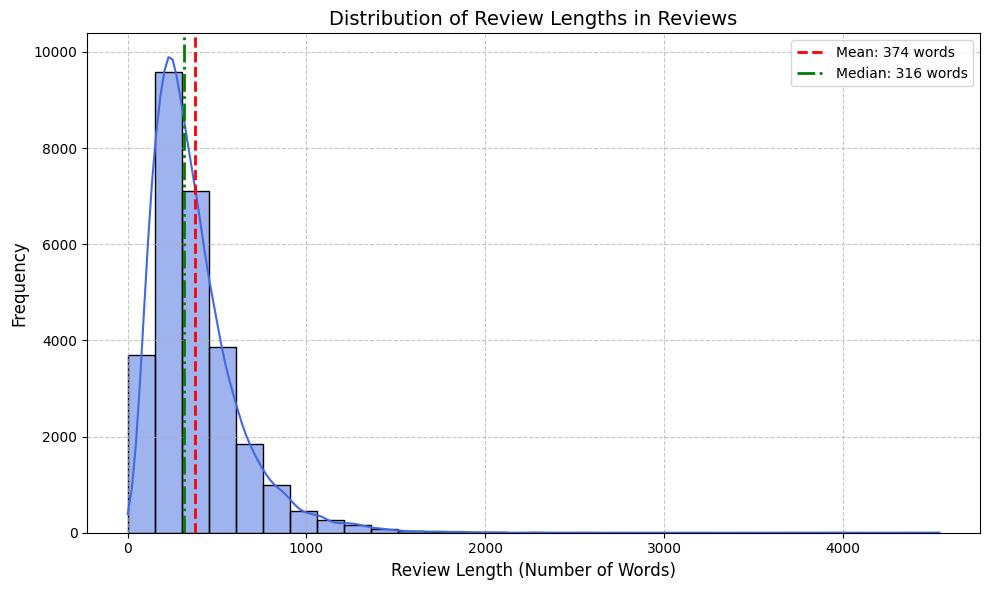

In [13]:
plt.figure(figsize=(10,6))

sns.histplot(reviews_df['review_length'], bins=30, kde=True, color='royalblue', edgecolor='black')

plt.axvline(reviews_df['review_length'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {reviews_df["review_length"].mean():.0f} words')
plt.axvline(reviews_df['review_length'].median(), color='green', linestyle='-.', linewidth=2, label=f'Median: {reviews_df["review_length"].median():.0f} words')

plt.xlabel('Review Length (Number of Words)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Review Lengths in Reviews', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [14]:
metadata_df = metadata_df.reset_index().rename(columns={'index': 'paper_idx'})
merged_df = reviews_df.copy()
merged_df['paper_id'] = merged_df.index

full_df = pd.merge(merged_df, metadata_df[['paper_idx', 'id', 'decision']], left_on='paper_id', right_on='paper_idx', how='left')
full_df['binary_decision'] = full_df['decision'].apply(lambda x: 'Accept' if pd.notnull(x) and 'Accept' in x else 'Reject')

accept_lengths = full_df[full_df['binary_decision'] == 'Accept']['review_length'].dropna()
reject_lengths = full_df[full_df['binary_decision'] == 'Reject']['review_length'].dropna()

u_stat, p_value = mannwhitneyu(accept_lengths, reject_lengths, alternative='two-sided')

print(f"\nMann-Whitney U Test:")
print(f"U statistic = {u_stat:.2f}")
print(f"P-value = {p_value:.5f}")

if p_value < 0.05:
    print("Result: Significant difference in review lengths between accepted and rejected papers (p < 0.05).")
else:
    print("Result: No significant difference in review lengths between accepted and rejected papers (p >= 0.05).")


if p_value < 0.05:
    print("There is a statistically significant difference between the review lengths for accepted and rejected papers.")
else:
    print("No statistically significant difference found between review lengths.")


Mann-Whitney U Test:
U statistic = 64299425.50
P-value = 0.00000
Result: Significant difference in review lengths between accepted and rejected papers (p < 0.05).
There is a statistically significant difference between the review lengths for accepted and rejected papers.


In [15]:
accept_reviews = full_df[full_df['binary_decision'] == 'Accept']['review_length'].dropna()
reject_reviews = full_df[full_df['binary_decision'] == 'Reject']['review_length'].dropna()

accept_stats = accept_reviews.describe()
reject_stats = reject_reviews.describe()

print("Descriptive Statistics for Accepted Submissions:")
print(accept_stats)
print("\nDescriptive Statistics for Rejected Submissions:")
print(reject_stats)

Descriptive Statistics for Accepted Submissions:
count    5408.000000
mean      387.132396
std       248.941547
min        11.000000
25%       219.000000
50%       330.000000
75%       495.000000
max      4540.000000
Name: review_length, dtype: float64

Descriptive Statistics for Rejected Submissions:
count    22714.000000
mean       371.454609
std        246.532206
min          1.000000
25%        204.000000
50%        314.000000
75%        472.000000
max       3968.000000
Name: review_length, dtype: float64


In [16]:
reviews_df['confidence_numeric'] = reviews_df['confidence'].str.extract(r'(\d)').astype(float)
print("Reviewer confidence statistics:")
print(reviews_df['confidence_numeric'].describe())

Reviewer confidence statistics:
count    12193.000000
mean         3.331994
std          1.086260
min          1.000000
25%          2.000000
50%          4.000000
75%          4.000000
max          5.000000
Name: confidence_numeric, dtype: float64


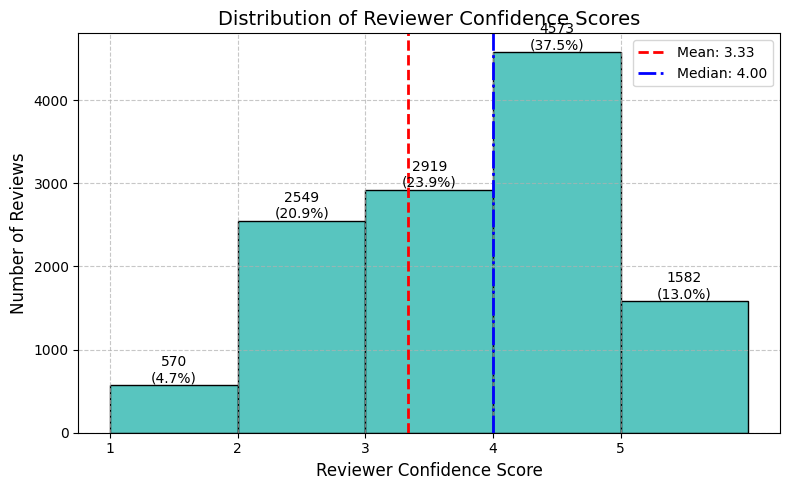

In [17]:
mean_conf = reviews_df['confidence_numeric'].mean()
median_conf = reviews_df['confidence_numeric'].median()

total_valid_confidences = reviews_df['confidence_numeric'].dropna().shape[0]

plt.figure(figsize=(8,5))
ax = sns.histplot(reviews_df['confidence_numeric'].dropna(), bins=[1, 2, 3, 4, 5, 6], kde=False, color='lightseagreen', edgecolor='black')

plt.axvline(mean_conf, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_conf:.2f}')
plt.axvline(median_conf, color='blue', linestyle='-.', linewidth=2, label=f'Median: {median_conf:.2f}')

for p in ax.patches:
    height = p.get_height()
    if height > 0:
        percentage = (height / total_valid_confidences) * 100
        ax.annotate(f'{int(height)}\n({percentage:.1f}%)', 
                    (p.get_x() + p.get_width() / 2., height), 
                    ha='center', va='bottom', fontsize=10)

plt.xlabel('Reviewer Confidence Score', fontsize=12)
plt.ylabel('Number of Reviews', fontsize=12)
plt.title('Distribution of Reviewer Confidence Scores', fontsize=14)
plt.xticks([1, 2, 3, 4, 5])
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [18]:
aspect_file = os.path.join(data_root, 'aspect_data', 'review_with_aspect.jsonl')
aspect_counts = Counter()

In [19]:
if os.path.exists(aspect_file):
    with open(aspect_file, 'r') as f:
        for line in f:
            data = json.loads(line)
            for label in data['labels']:
                aspect_label = label[2]
                aspect_counts[aspect_label] += 1

In [20]:
print("Aspect class distribution:")
for aspect, count in aspect_counts.most_common():
    print(f"{aspect}: {count}")

Aspect class distribution:
summary: 23946
clarity_negative: 15697
soundness_negative: 15662
clarity_positive: 13095
soundness_positive: 12780
substance_negative: 11717
originality_positive: 11606
motivation_positive: 11121
meaningful_comparison_negative: 9242
originality_negative: 8745
substance_positive: 4669
replicability_negative: 4548
motivation_negative: 3499
meaningful_comparison_positive: 1488
replicability_positive: 271


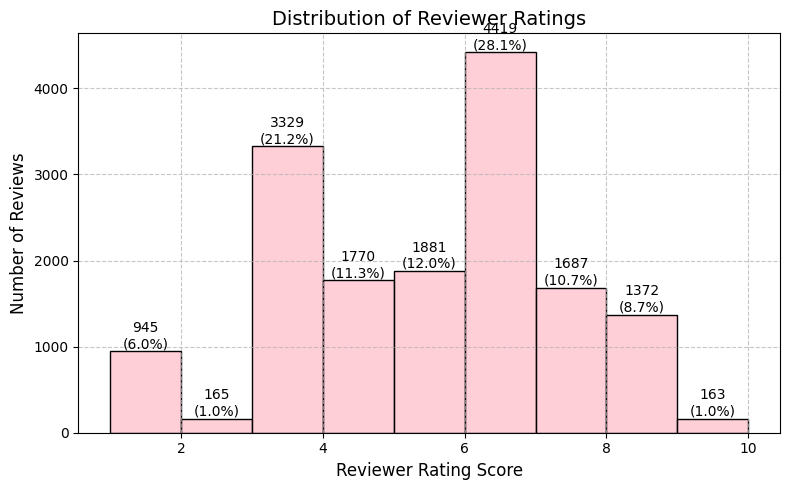

In [21]:
reviews_df['rating_numeric'] = reviews_df['rating'].str.extract(r'(\d+)').astype(float)

plt.figure(figsize=(8,5))
ax = sns.histplot(reviews_df['rating_numeric'].dropna(), bins=range(1, 11), kde=False, color='pink', edgecolor='black')

total_valid_ratings = reviews_df['rating_numeric'].dropna().shape[0]
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        percentage = (height / total_valid_ratings) * 100
        ax.annotate(f'{int(height)}\n({percentage:.1f}%)', 
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom', fontsize=10)

plt.xlabel('Reviewer Rating Score', fontsize=12)
plt.ylabel('Number of Reviews', fontsize=12)
plt.title('Distribution of Reviewer Ratings', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [22]:
conf_rating_df = reviews_df.dropna(subset=['confidence_numeric', 'rating_numeric'])

corr_coef, p_value = pearsonr(conf_rating_df['confidence_numeric'], conf_rating_df['rating_numeric'])

print(f"Pearson Correlation between Reviewer Confidence and Rating: {corr_coef:.3f}")
print(f"P-value: {p_value:.5f}")

Pearson Correlation between Reviewer Confidence and Rating: -0.139
P-value: 0.00000


/var/folders/zn/vf7dcg9j5yx547py9_y411jw0000gn/T/ipykernel_61885/3385265180.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=full_df, x='binary_decision', y='review_length', palette='Set2')


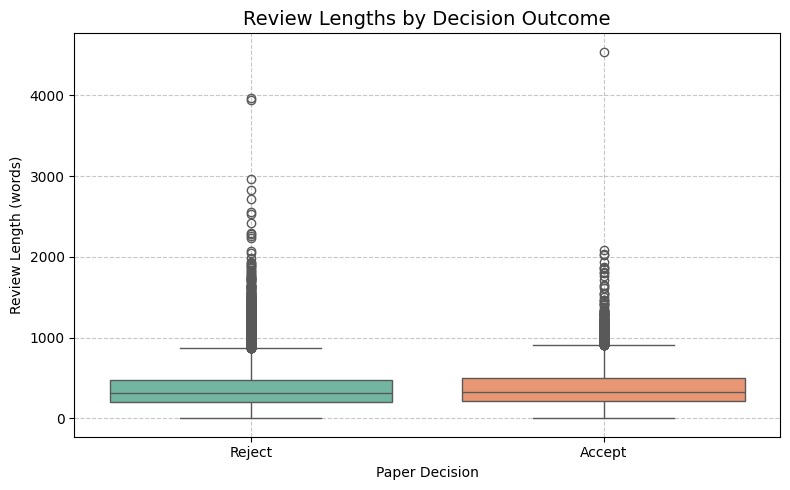

/var/folders/zn/vf7dcg9j5yx547py9_y411jw0000gn/T/ipykernel_61885/3385265180.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=full_df, x='binary_decision', y='confidence_numeric', palette='Set3')


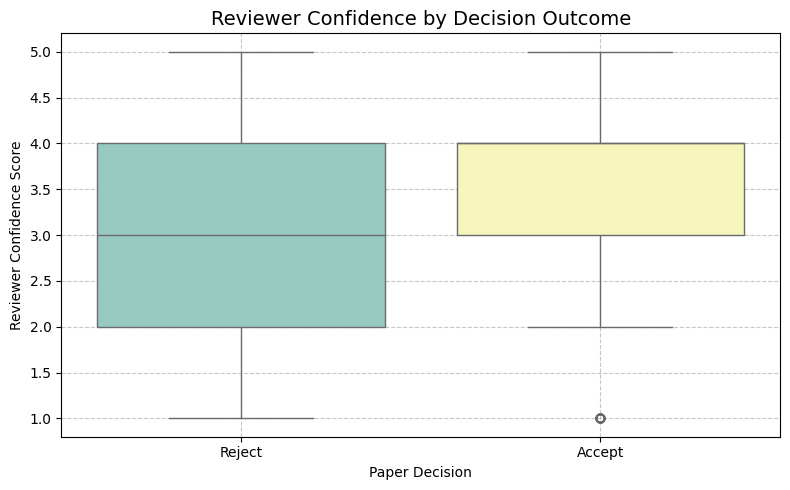

In [23]:
merged_df = reviews_df.copy()
merged_df['paper_id'] = merged_df.index.map(lambda idx: reviews_df.index[idx] if idx in reviews_df.index else None)
metadata_df['paper_id'] = metadata_df.index
full_df = pd.merge(merged_df, metadata_df[['id', 'decision']], left_on='paper_id', right_index=True, how='left')

full_df['binary_decision'] = full_df['decision'].apply(lambda x: 'Accept' if pd.notnull(x) and 'Accept' in x else 'Reject')

plt.figure(figsize=(8,5))
sns.boxplot(data=full_df, x='binary_decision', y='review_length', palette='Set2')
plt.title('Review Lengths by Decision Outcome', fontsize=14)
plt.ylabel('Review Length (words)')
plt.xlabel('Paper Decision')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,5))
sns.boxplot(data=full_df, x='binary_decision', y='confidence_numeric', palette='Set3')
plt.title('Reviewer Confidence by Decision Outcome', fontsize=14)
plt.ylabel('Reviewer Confidence Score')
plt.xlabel('Paper Decision')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [24]:
def has_meta_review(file_path):
    if not os.path.exists(file_path):
        return False
    with open(file_path, 'r') as f:
        review_data = json.load(f)
        return 'metaReview' in review_data and isinstance(review_data['metaReview'], str) and len(review_data['metaReview'].strip()) > 0

meta_review_count = 0
total_papers_checked = 0

for conf in ['ICLR_2018', 'ICLR_2019', 'ICLR_2020', 'NIPS_2019']:  # Only these years have meta-reviews
    review_folder = os.path.join(data_root, conf, f"{conf}_review")
    if os.path.exists(review_folder):
        for file_name in os.listdir(review_folder):
            if file_name.endswith('.json'):
                file_path = os.path.join(review_folder, file_name)
                total_papers_checked += 1
                if has_meta_review(file_path):
                    meta_review_count += 1

print(f"Meta reviews found for {meta_review_count} papers out of {total_papers_checked} papers ({meta_review_count / total_papers_checked * 100:.2f}%).")

Meta reviews found for 5924 papers out of 6077 papers (97.48%).


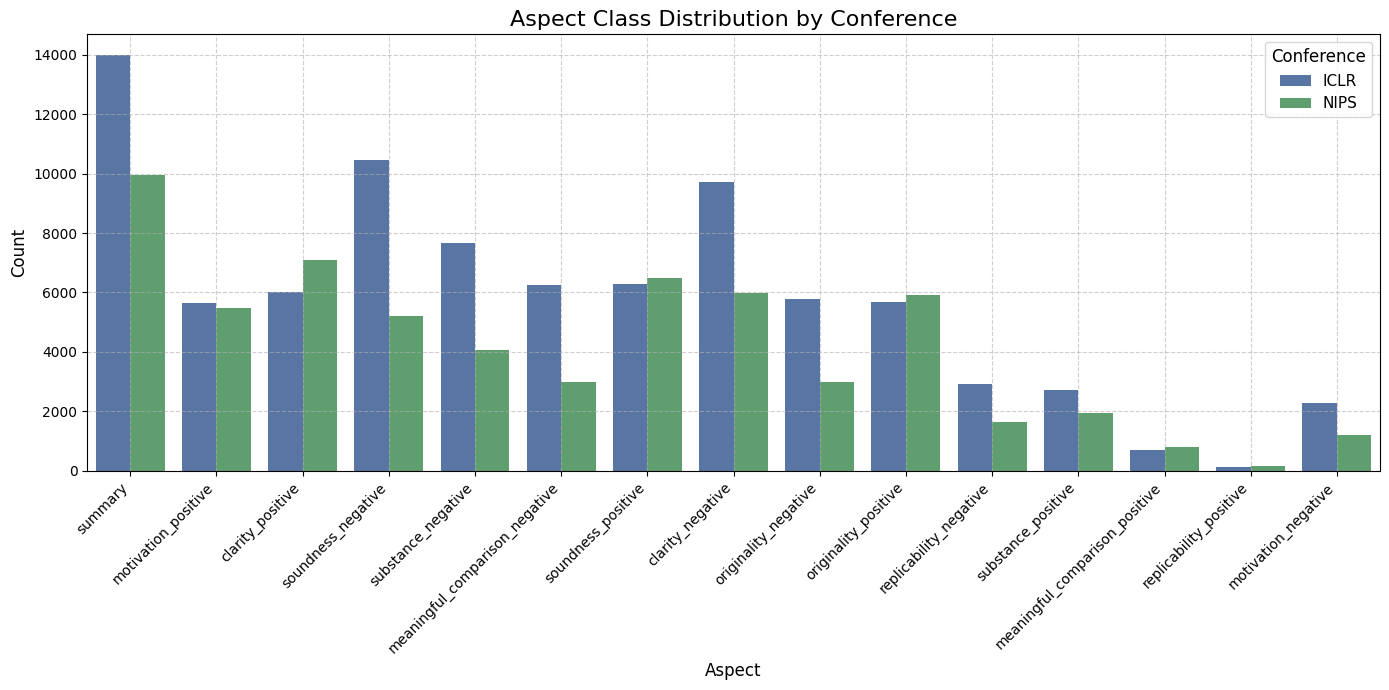

In [25]:
custom_palette = {
    "ICLR": "#4C72B0",   # soft blue
    "NIPS": "#55A868"    # soft green
}
aspect_conference_counts = {}

if os.path.exists(aspect_file):
    with open(aspect_file, 'r') as f:
        for line in f:
            data = json.loads(line)
            paper_id = data['id']
            conference = paper_id.split('_')[0]  # e.g., ICLR or NIPS
            for label in data['labels']:
                aspect_label = label[2]
                key = (conference, aspect_label)
                if key not in aspect_conference_counts:
                    aspect_conference_counts[key] = 0
                aspect_conference_counts[key] += 1
                
aspect_conf_df = pd.DataFrame([(k[0], k[1], v) for k, v in aspect_conference_counts.items()],
                              columns=['Conference', 'Aspect', 'Count'])

plt.figure(figsize=(14,7))
sns.barplot(data=aspect_conf_df, x='Aspect', y='Count', hue='Conference', palette=custom_palette)

plt.title('Aspect Class Distribution by Conference', fontsize=16)
plt.xlabel('Aspect', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Conference', title_fontsize=12, fontsize=11)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

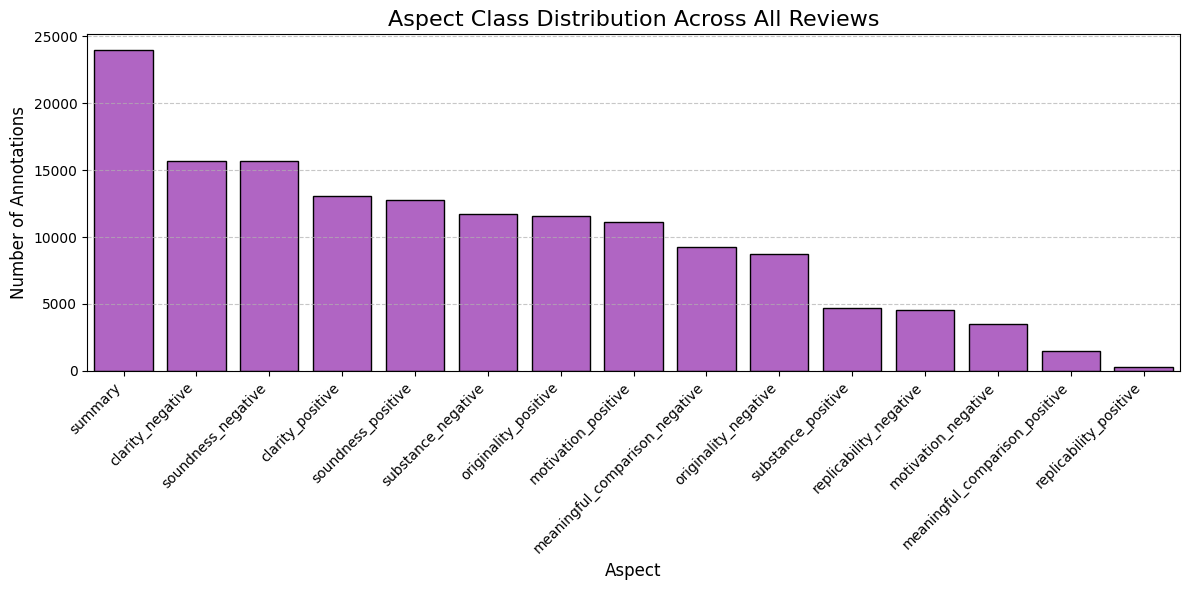

In [26]:
aspect_counts = {}

if os.path.exists(aspect_file):
    with open(aspect_file, 'r') as f:
        for line in f:
            data = json.loads(line)
            for label in data['labels']:
                aspect_label = label[2]
                if aspect_label not in aspect_counts:
                    aspect_counts[aspect_label] = 0
                aspect_counts[aspect_label] += 1

aspect_df = pd.DataFrame(list(aspect_counts.items()), columns=['Aspect', 'Count'])
aspect_df = aspect_df.sort_values(by='Count', ascending=False)

plt.figure(figsize=(12,6))
sns.barplot(data=aspect_df, x='Aspect', y='Count', color='#BA55D3', edgecolor='black')

plt.title('Aspect Class Distribution Across All Reviews', fontsize=16)
plt.xlabel('Aspect', fontsize=12)
plt.ylabel('Number of Annotations', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Content Availability among Papers:
hasContent
true     8846
false      31
Name: count, dtype: int64


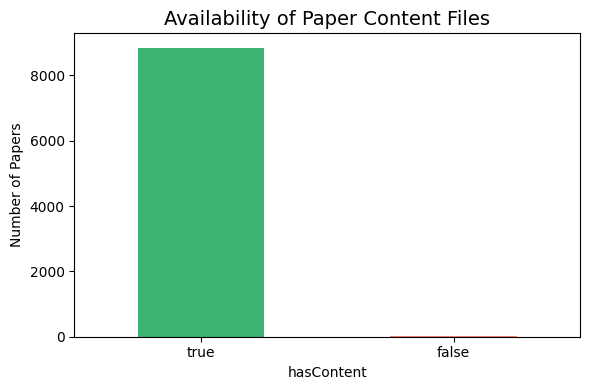

In [27]:
content_availability = metadata_df['hasContent'].value_counts()

print("Content Availability among Papers:")
print(content_availability)

plt.figure(figsize=(6,4))
content_availability.plot(kind='bar', color=['mediumseagreen', 'salmon'])
plt.title('Availability of Paper Content Files', fontsize=14)
plt.ylabel('Number of Papers')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()